In [1]:
%matplotlib inline
import os, glob
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [2]:
#readint the file into dataframe
data_path = 'C:/Users/mushraf/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/'
train_path = data_path + 'Train/'
test_path = data_path + 'Test/'
meta_df = pd.read_csv(data_path + 'Meta.csv') 
train_df = pd.read_csv(data_path + 'Train.csv')
test_df = pd.read_csv(data_path + 'Test.csv')

In [3]:
meta_df.head(5)

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [4]:
test_df.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [5]:
train_df.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [6]:
#number of classes
print("Min. Class Label: {}".format(meta_df.ClassId.min()))
print("Max Class Label: {}".format(meta_df.ClassId.max()))
print("Total Class Labels: {}".format(len(meta_df.ClassId.unique())))

Min. Class Label: 0
Max Class Label: 42
Total Class Labels: 43


In [7]:
num_classes = len(meta_df.ClassId.unique())
class_dict = {}
class_labels = list(range(num_classes))
# Speed Class 0-9
speed_class = ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['20', '30', '50', '60', '70', '80']]]\
            + ['End of Speed Limit 80 kmph']
speed_class+= ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['100', '120']]]
speed_class
# 10, 11 No Passing
no_pass = ['No Passing' + item for item in ['', ' vehicle over 3.5 ton']]
# 12-43
rest = ['Right-of-way at intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited',\
            'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road',
            'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing',
            'Bicycles crossing', 'Beware of ice/snow','Wild animals crossing', 'End speed + passing limits', 'Turn right ahead',
            'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left',
            'Roundabout mandatory', 'End of no passing', 'End no passing vehicle > 3.5 tons']
class_values = speed_class + no_pass + rest
class_dict = {keys:values for keys,values in zip(class_labels, class_values)}

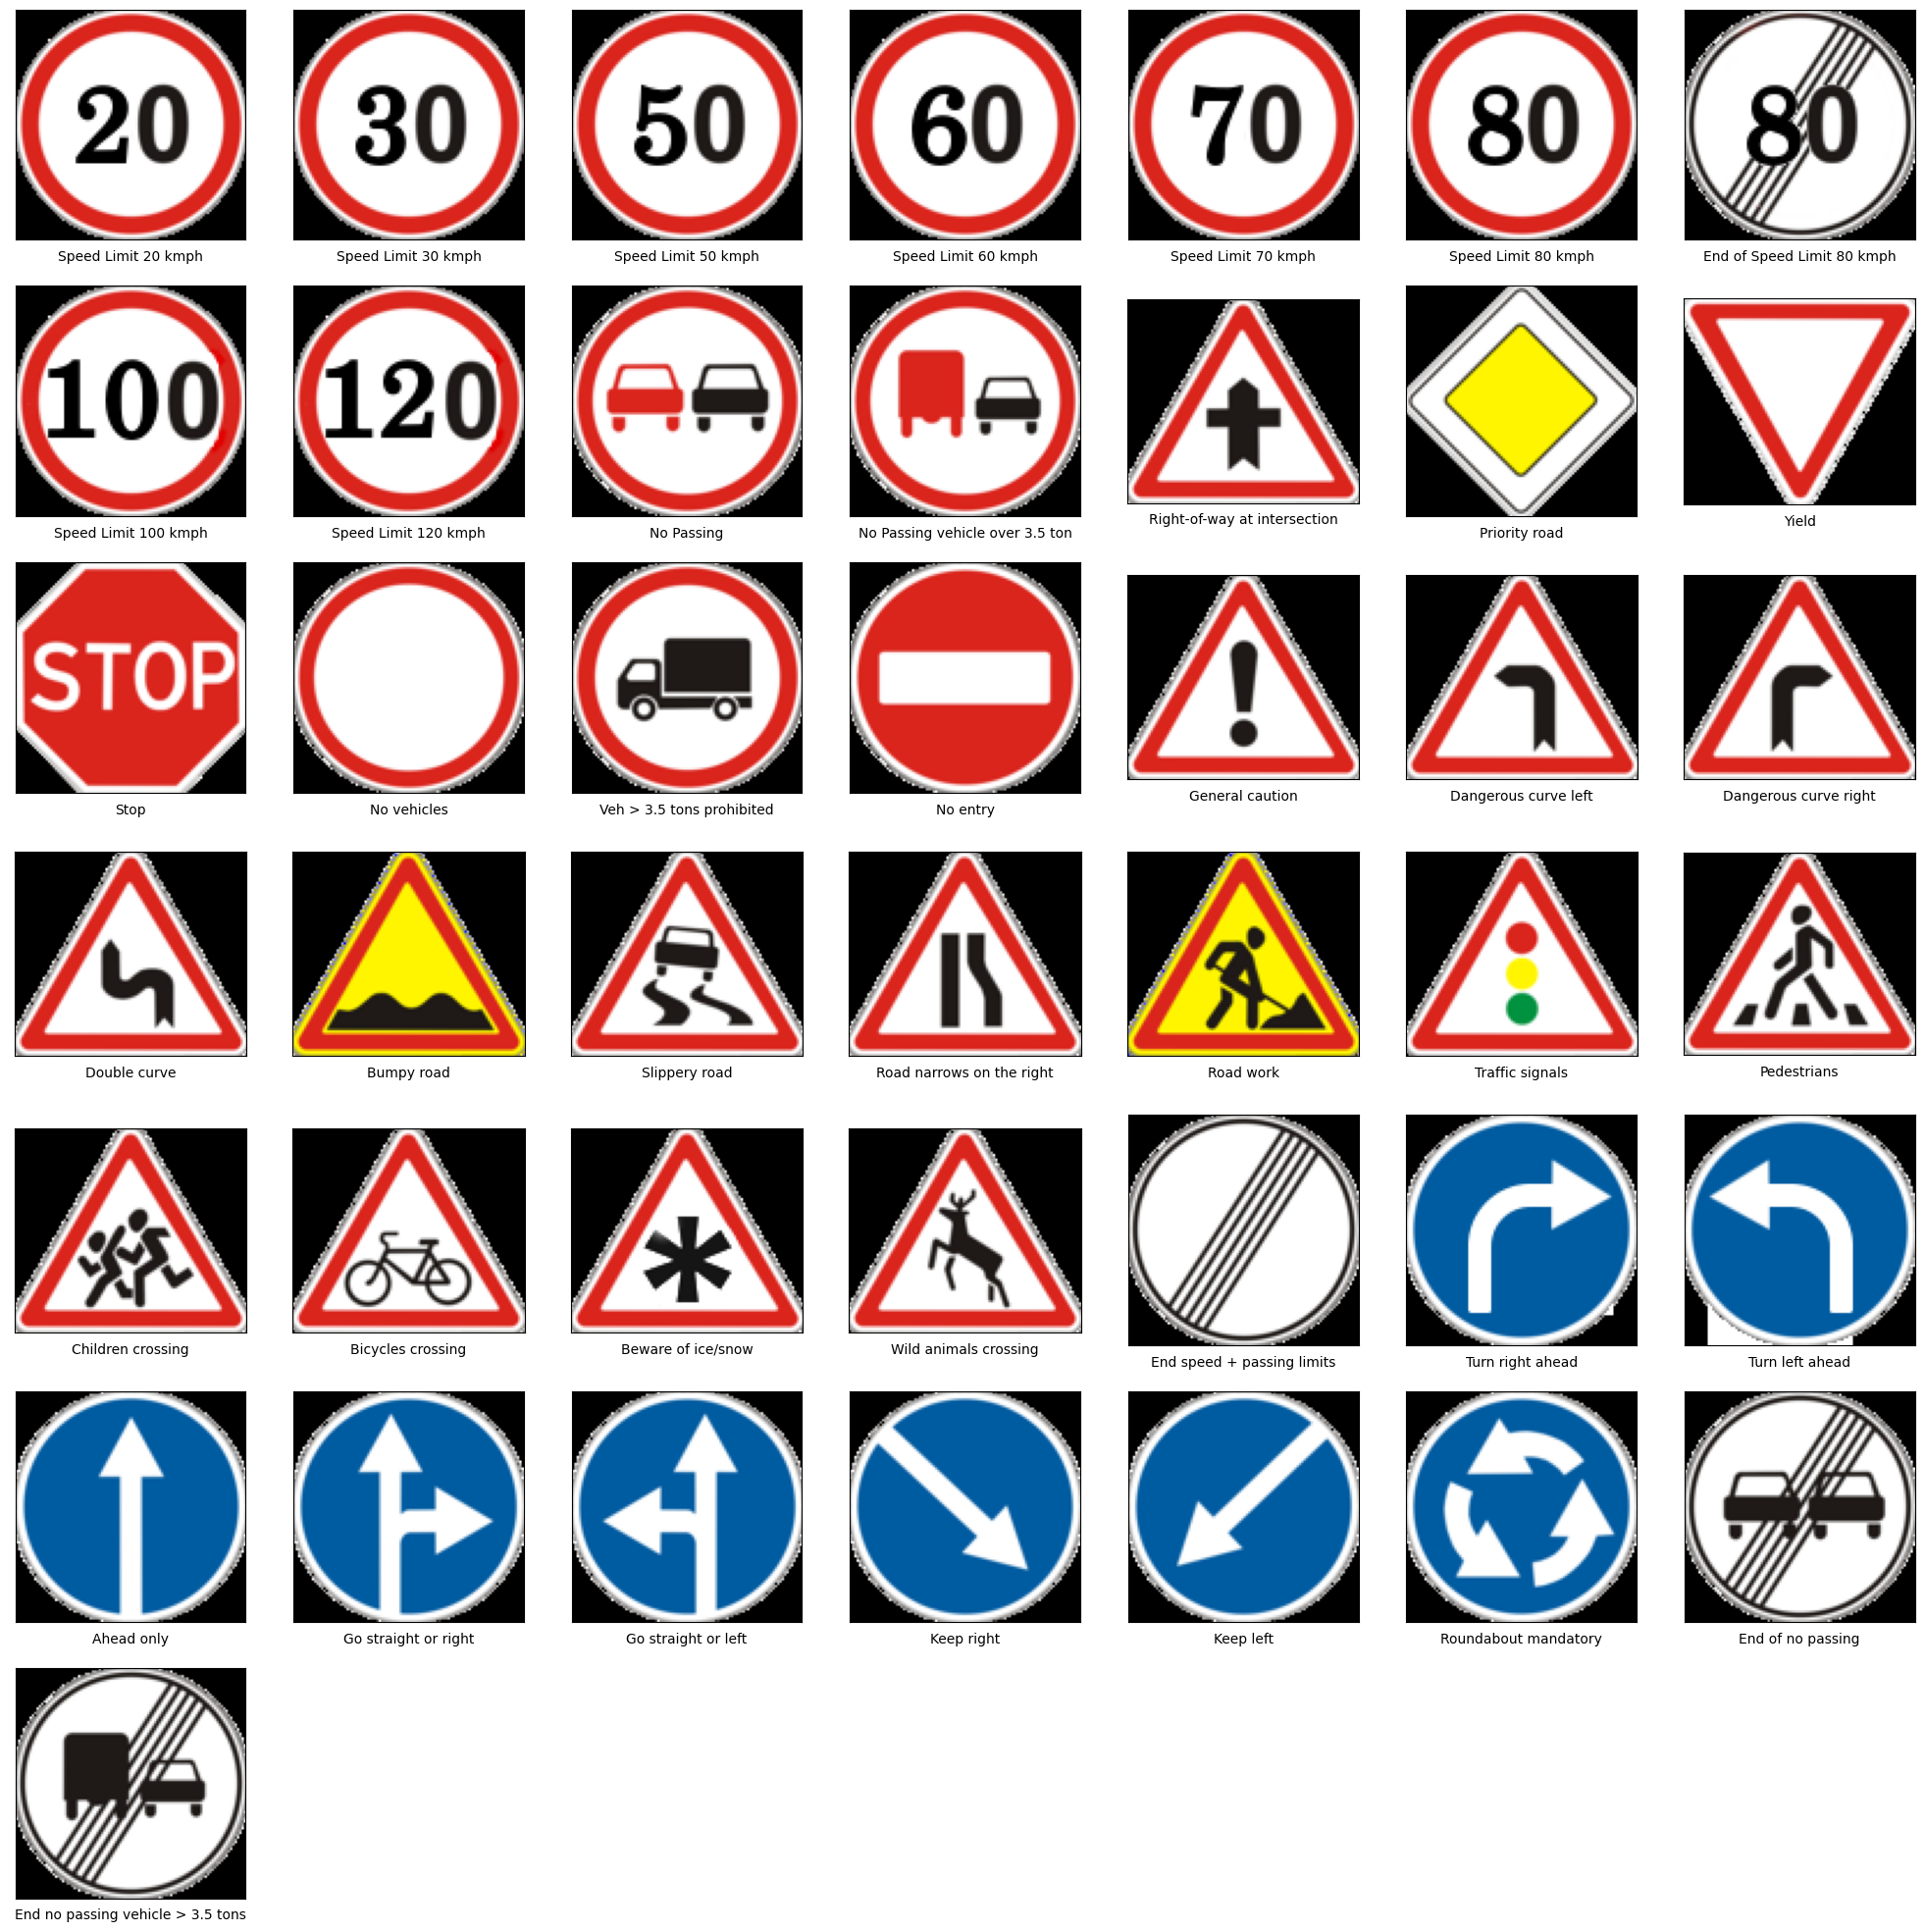

In [8]:
sortFunction = lambda x: int(os.path.basename(x)[:-4])
plt.figure(figsize = (25, 25))
for i, imagename in enumerate(sorted(glob.glob(data_path + 'Meta/' + '*.*'), key = sortFunction)):
    plt.subplot(7, 7, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_dict[i])
    image = cv2.imread(imagename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
shape_dict = {0: 'Triangle', 1: 'Circle', 2: 'Diamond', 3: 'Hexagon', 4: 'Inverse Triangle'}
meta_df.ShapeId.value_counts()

1    25
0    15
2     1
4     1
3     1
Name: ShapeId, dtype: int64

In [10]:
train_df.ClassId.value_counts()

2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
18    1200
35    1200
17    1110
14     780
31     780
33     689
15     630
26     600
28     540
23     510
30     450
16     420
6      420
34     420
22     390
36     390
40     360
20     360
21     330
39     300
29     270
24     270
32     240
27     240
41     240
42     240
37     210
0      210
19     210
Name: ClassId, dtype: int64

In [11]:
# Create a dictionary which consists of the labels as keys and the number of samples as values
train_dict = {}
train_dict = {keys:values for keys,values in zip(train_df.ClassId.value_counts().index, train_df.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Class Distribution for Training data')

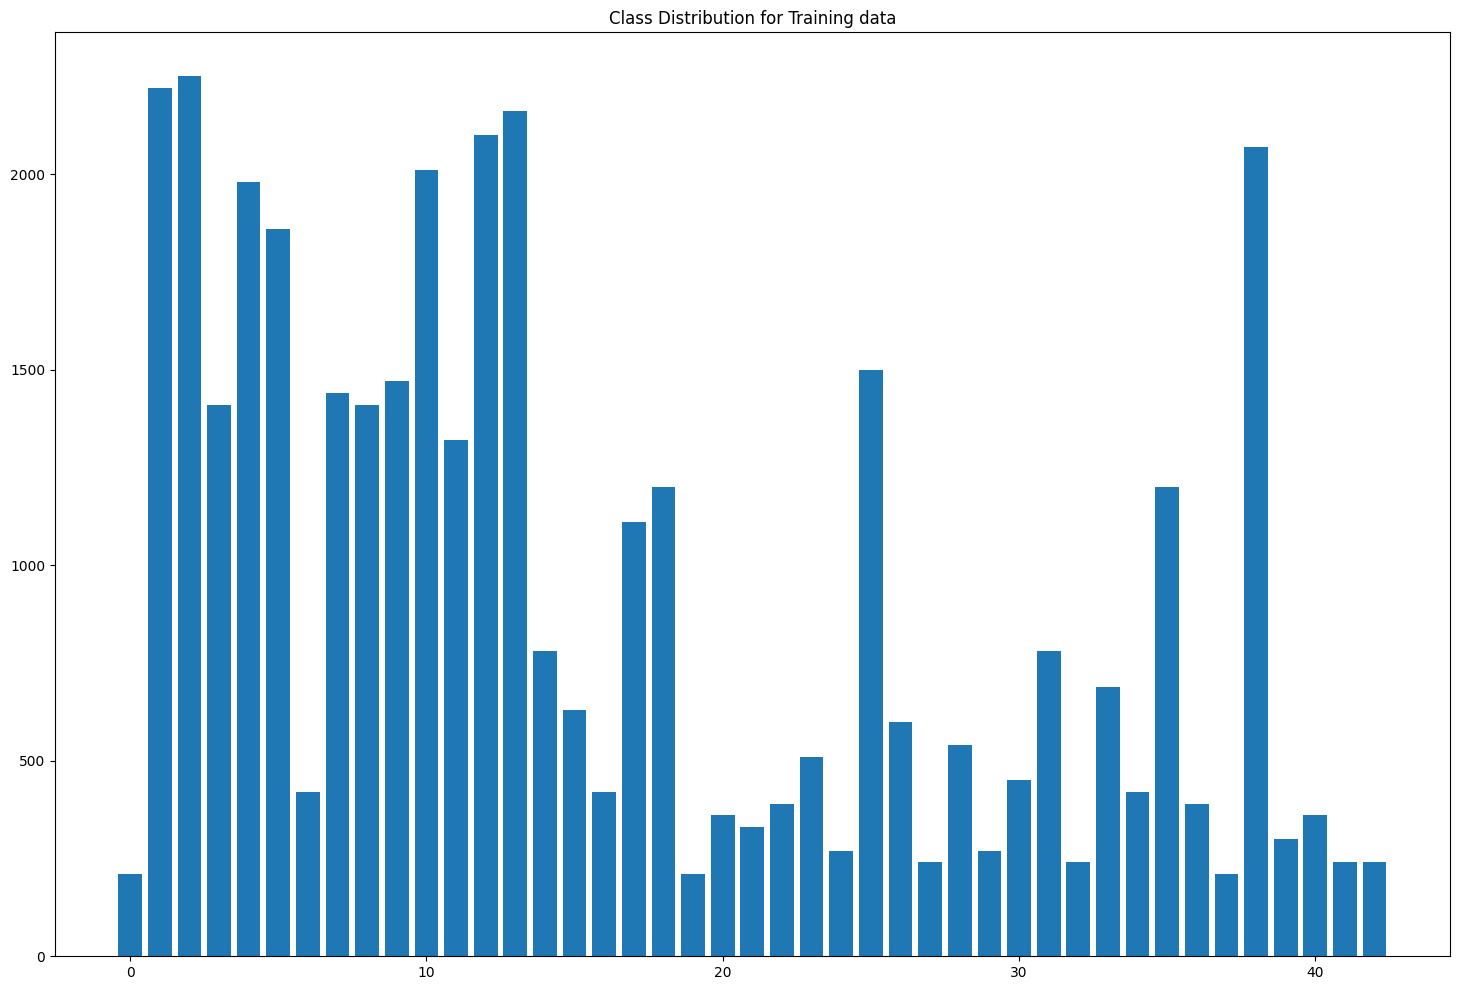

In [12]:
plt.figure(figsize = (18 ,12))
plt.bar(train_dict.keys(), train_dict.values())
plt.title('Class Distribution for Training data')

In [13]:
# Check the dataframe information with folder directory
train_folders = os.listdir(train_path)
# Create a dict with keys as label names and the number of images present inside each label folder as values
sample_dict = {}
for folders in train_folders:
    images = os.listdir(train_path + folders)
    sample_dict[folders] = len(images)
train_sample_dict = {int(k):v for k,v in zip(sample_dict.keys(), sample_dict.values())}
train_dict==train_sample_dict

True

In [14]:
#Test Dataframe
#Create a dictionary test_dict with labels as keys and value_counts as values


In [15]:
test_df.shape

(12630, 8)

In [16]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [17]:
test_df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [18]:
test_df.ClassId.value_counts()

2     750
1     720
13    720
38    690
12    690
4     660
10    660
5     630
9     480
25    480
3     450
8     450
7     450
11    420
35    390
18    390
17    360
31    270
14    270
15    210
33    210
26    180
30    150
16    150
28    150
6     150
23    150
22    120
36    120
34    120
24     90
29     90
20     90
40     90
21     90
39     90
42     90
32     60
27     60
41     60
19     60
0      60
37     60
Name: ClassId, dtype: int64

In [19]:
# Create a test_dict with keys as the labels and values as the value_counts
test_dict = {}
test_dict = {keys:values for keys,values in zip(test_df.ClassId.value_counts().index, test_df.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Class Distribution of Test Data')

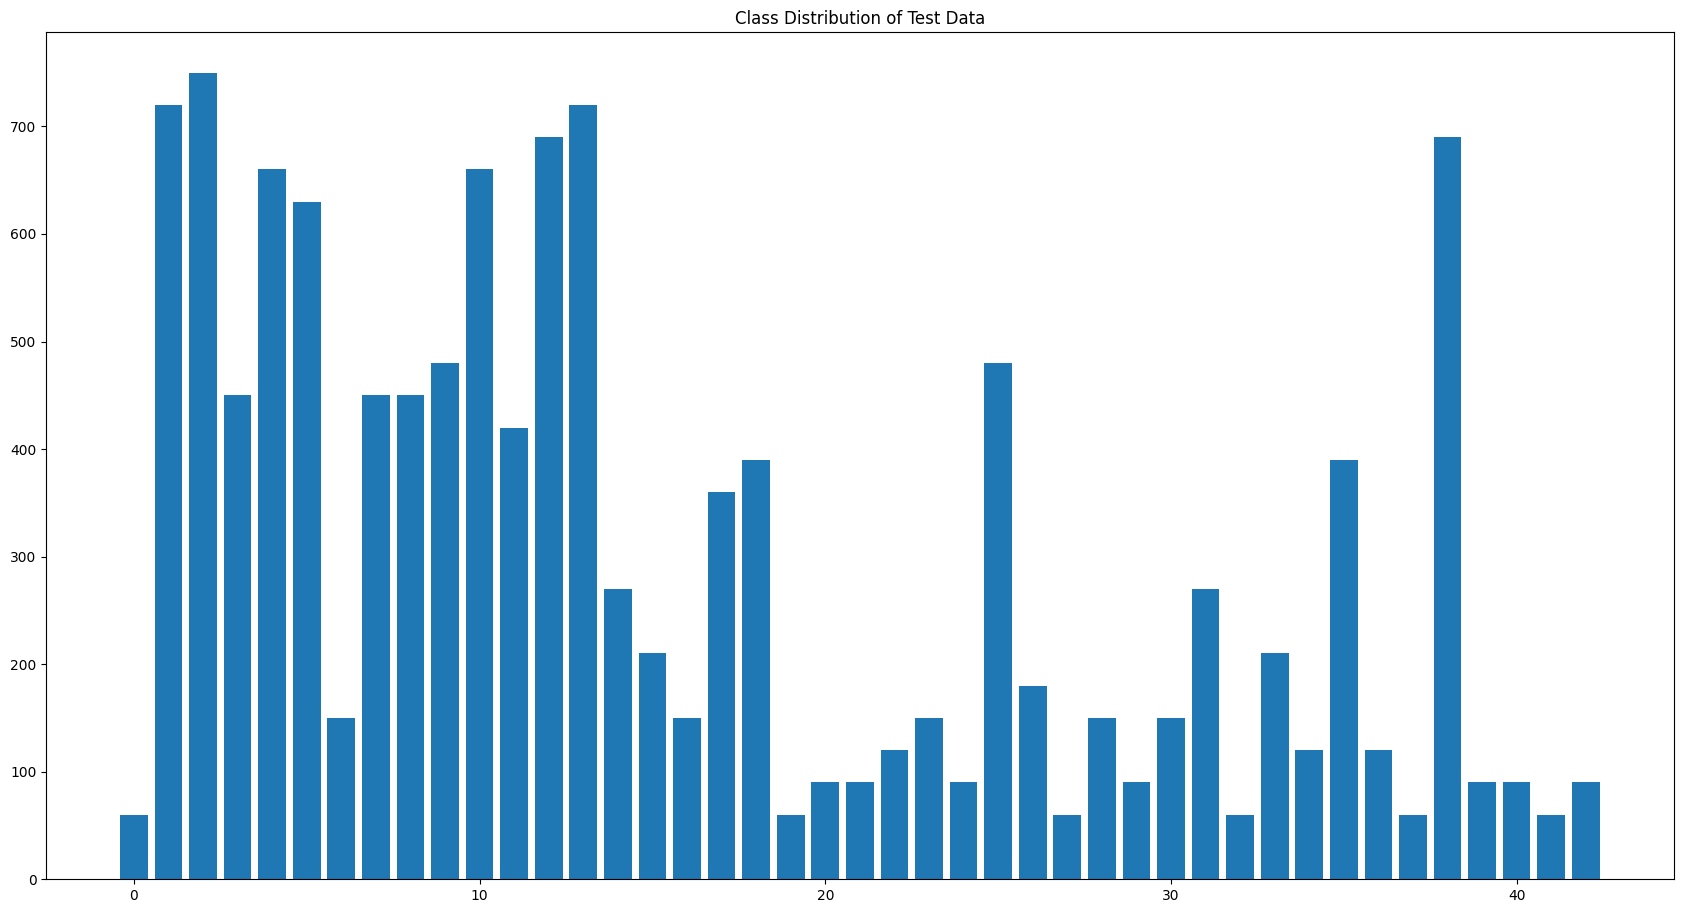

In [20]:
plt.figure(figsize = (21, 11))
plt.bar(test_dict.keys(), test_dict.values())
plt.title("Class Distribution of Test Data")

In [21]:
#checking Data imbalance
# we are goona measure the label-wise train test ratio because we will be splitting the training data into train and validation.

Class Balance Analysis (First 10 Classes):


,Class,Train_Count,Test_Count,Total_Count,Train_Ratio,Test_Ratio,Percentage_of_Dataset
0,0,210,60,270,0.777778,0.222222,0.520843
1,1,2220,720,2940,0.755102,0.244898,5.671406
2,2,2250,750,3000,0.750000,0.250000,5.787149
3,3,1410,450,1860,0.758065,0.241935,3.588032
4,4,1980,660,2640,0.750000,0.250000,5.092691
5,5,1860,630,2490,0.746988,0.253012,4.803333
6,6,420,150,570,0.736842,0.263158,1.099558
7,7,1440,450,1890,0.761905,0.238095,3.645904
8,8,1410,450,1860,0.758065,0.241935,3.588032
9,9,1470,480,1950,0.753846,0.246154,3.761647


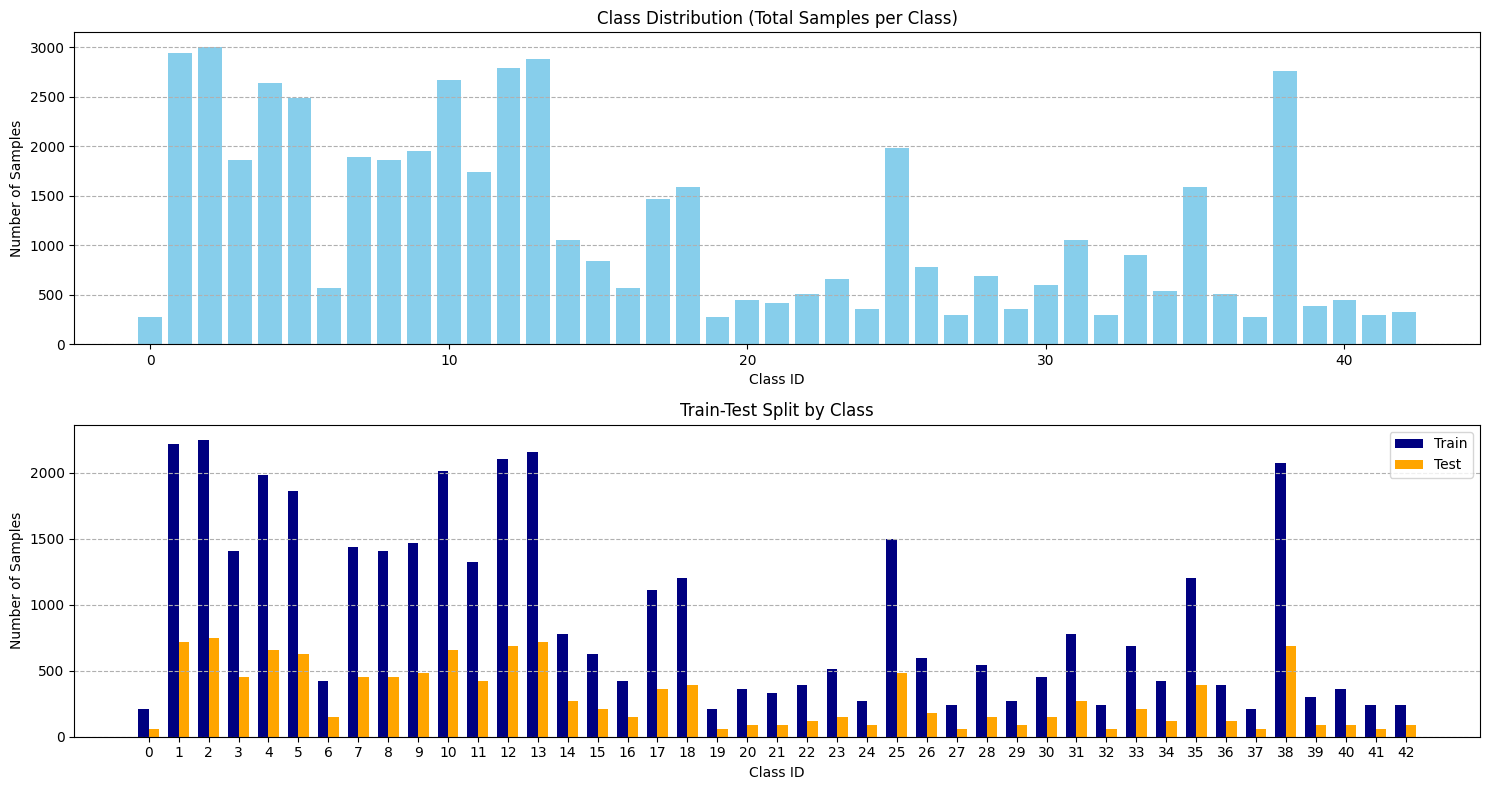

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def analyze_class_balance(train_df, test_df, class_column='ClassId'):
    """
    Analyze and visualize the class distribution and train-test balance
    
    Parameters:
    train_df (pd.DataFrame): Training dataset
    test_df (pd.DataFrame): Testing dataset
    class_column (str): Name of the column containing class labels
    """
    # Get class counts for train and test sets
    train_counts = train_df[class_column].value_counts().sort_index()
    test_counts = test_df[class_column].value_counts().sort_index()
    
    # Create a DataFrame for analysis
    balance_df = pd.DataFrame({
        'Class': train_counts.index,
        'Train_Count': train_counts.values,
        'Test_Count': test_counts.values
    })
    
    # Calculate additional metrics
    balance_df['Total_Count'] = balance_df['Train_Count'] + balance_df['Test_Count']
    balance_df['Train_Ratio'] = balance_df['Train_Count'] / balance_df['Total_Count']
    balance_df['Test_Ratio'] = balance_df['Test_Count'] / balance_df['Total_Count']
    balance_df['Percentage_of_Dataset'] = balance_df['Total_Count'] / balance_df['Total_Count'].sum() * 100
    
    # Display the first 10 classes
    print("Class Balance Analysis (First 10 Classes):")
    display(balance_df.head(10))
    
    # Visualization
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Class distribution
    plt.subplot(2, 1, 1)
    plt.bar(balance_df['Class'], balance_df['Total_Count'], color='skyblue')
    plt.title('Class Distribution (Total Samples per Class)')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.grid(axis='y', linestyle='--')
    
    # Plot 2: Train-test ratio
    plt.subplot(2, 1, 2)
    width = 0.35
    x = np.arange(len(balance_df['Class']))
    plt.bar(x - width/2, balance_df['Train_Count'], width, label='Train', color='navy')
    plt.bar(x + width/2, balance_df['Test_Count'], width, label='Test', color='orange')
    plt.title('Train-Test Split by Class')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.xticks(x, balance_df['Class'])
    
    plt.tight_layout()
    plt.show()
    
    return balance_df

# Usage
balance_analysis = analyze_class_balance(train_df, test_df)

In [23]:
balance_analysis 

,Class,Train_Count,Test_Count,Total_Count,Train_Ratio,Test_Ratio,Percentage_of_Dataset
0,0,210,60,270,0.777778,0.222222,0.520843
1,1,2220,720,2940,0.755102,0.244898,5.671406
2,2,2250,750,3000,0.750000,0.250000,5.787149
3,3,1410,450,1860,0.758065,0.241935,3.588032
4,4,1980,660,2640,0.750000,0.250000,5.092691
5,5,1860,630,2490,0.746988,0.253012,4.803333
6,6,420,150,570,0.736842,0.263158,1.099558
7,7,1440,450,1890,0.761905,0.238095,3.645904
8,8,1410,450,1860,0.758065,0.241935,3.588032
9,9,1470,480,1950,0.753846,0.246154,3.761647


In [24]:
#checking duplicates
train_df.Path.duplicated().unique()

array([False])

In [25]:
test_df.Path.duplicated().unique()

array([False])

In [26]:
#No duplicate entries found in train and test csv files

In [27]:
#Data Preprocessing (Train 60% ,Val 15% ,Test 25%

In [28]:

train_data = []
train_labels = []
for folders in tqdm.tqdm(train_folders):
    imagefiles = os.listdir(train_path + folders)
    for imagefile in imagefiles:
        path = os.path.join(train_path, folders, imagefile)
        image = Image.open(path)
        image = image.resize((32, 32))
        image = np.array(image)
        train_data.append(image)
        train_labels.append(int(folders))

100%|██████████| 43/43 [00:18<00:00,  2.31it/s]


In [29]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)
len(train_df), len(train_data), len(train_labels)

(39209, 39209, 39209)

In [30]:
print("dimension for the images  : {}".format(train_data[0].shape))

dimension for the images  : (32, 32, 3)


Image dimensions: (32, 32, 3)
Training set shape: (31367, 32, 32, 3) (31367, 43)
Validation set shape: (7842, 32, 32, 3) (7842, 43)


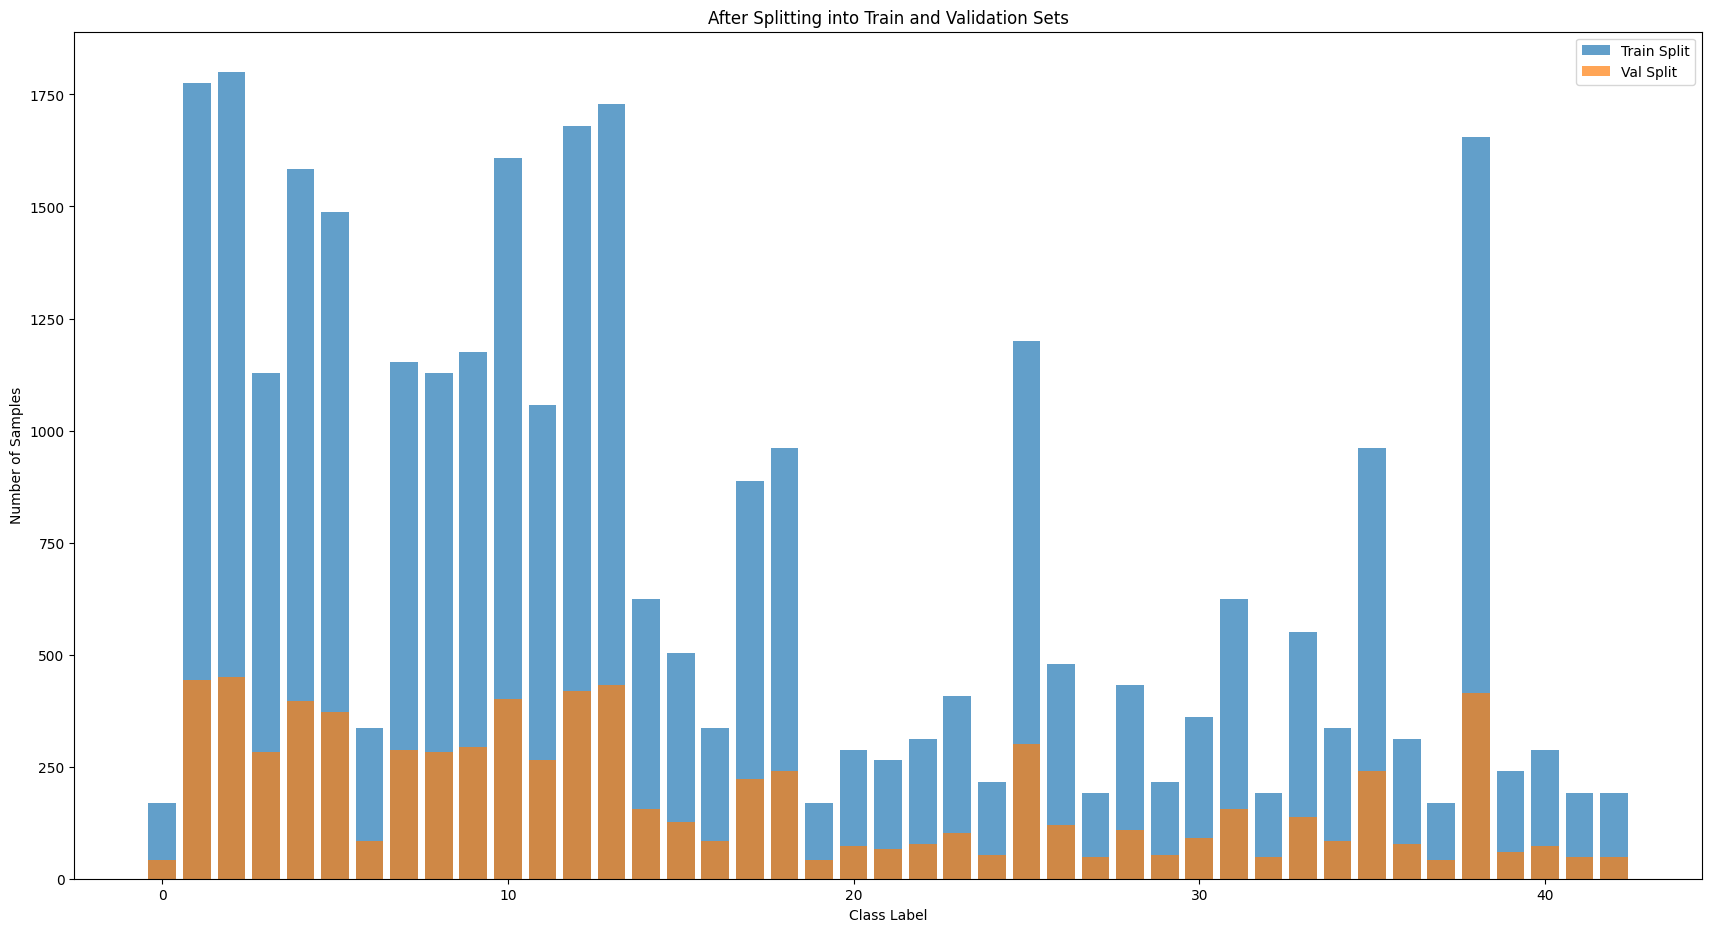

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Display image dimensions
print("Image dimensions:", train_data[0].shape)

# Split dataset into train and validation
def split_dataset(X, y, test_ratio=0.2, seed=42):
    return train_test_split(X, y, test_size=test_ratio, stratify=y, random_state=seed)

X_train, X_val, y_train, y_val = split_dataset(train_data, train_labels)

# Check class distribution
def class_distribution(labels):
    unique_classes, counts = np.unique(labels, return_counts=True)
    return unique_classes, counts

train_unique, train_counts = class_distribution(y_train)
val_unique, val_counts = class_distribution(y_val)

# Convert labels to categorical
num_classes = len(np.unique(train_labels))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

# Print dataset shapes
print("Training set shape:", X_train.shape, y_train_cat.shape)
print("Validation set shape:", X_val.shape, y_val_cat.shape)

# Plot class distributions
def plot_class_distribution(train_data, train_counts, val_data, val_counts):
    plt.figure(figsize=(21, 11))
    plt.bar(train_data, train_counts, alpha=0.7, label="Train Split")
    plt.bar(val_data, val_counts, alpha=0.7, label="Val Split")
    plt.legend(loc='upper right')
    plt.title("After Splitting into Train and Validation Sets")
    plt.xlabel("Class Label")
    plt.ylabel("Number of Samples")
    plt.show()

plot_class_distribution(train_unique, train_counts, val_unique, val_counts)

In [32]:
test_data = []
test_ground_truth = test_df.ClassId.tolist()
test_filenames = (data_path + test_df.Path).tolist()
for test_filename in tqdm.tqdm(test_filenames):
    image_filename = Image.open(test_filename)
    image = image_filename.resize((32, 32))
    image = np.array(image)
    test_data.append(image)

100%|██████████| 12630/12630 [00:06<00:00, 1955.07it/s]


In [33]:
X_test = np.array(test_data)
y_test = np.array(test_ground_truth)

In [34]:
test_unique, y_test_count = np.unique(y_test, return_counts = True)

In [35]:
balance_analysis ['val'] = val_counts
balance_analysis ['val_ratio'] = balance_analysis ['val']/balance_analysis ['Total_Count']
balance_analysis ['Train_Ratio'] = balance_analysis ['Train_Ratio'] - balance_analysis ['val_ratio']
balance_analysis .head()

,Class,Train_Count,Test_Count,Total_Count,Train_Ratio,Test_Ratio,Percentage_of_Dataset,val,val_ratio
0,0,210,60,270,0.622222,0.222222,0.520843,42,0.155556
1,1,2220,720,2940,0.604082,0.244898,5.671406,444,0.151020
2,2,2250,750,3000,0.600000,0.250000,5.787149,450,0.150000
3,3,1410,450,1860,0.606452,0.241935,3.588032,282,0.151613
4,4,1980,660,2640,0.600000,0.250000,5.092691,396,0.150000


<AxesSubplot:title={'center':'Train Val Test Split'}, xlabel='Class'>

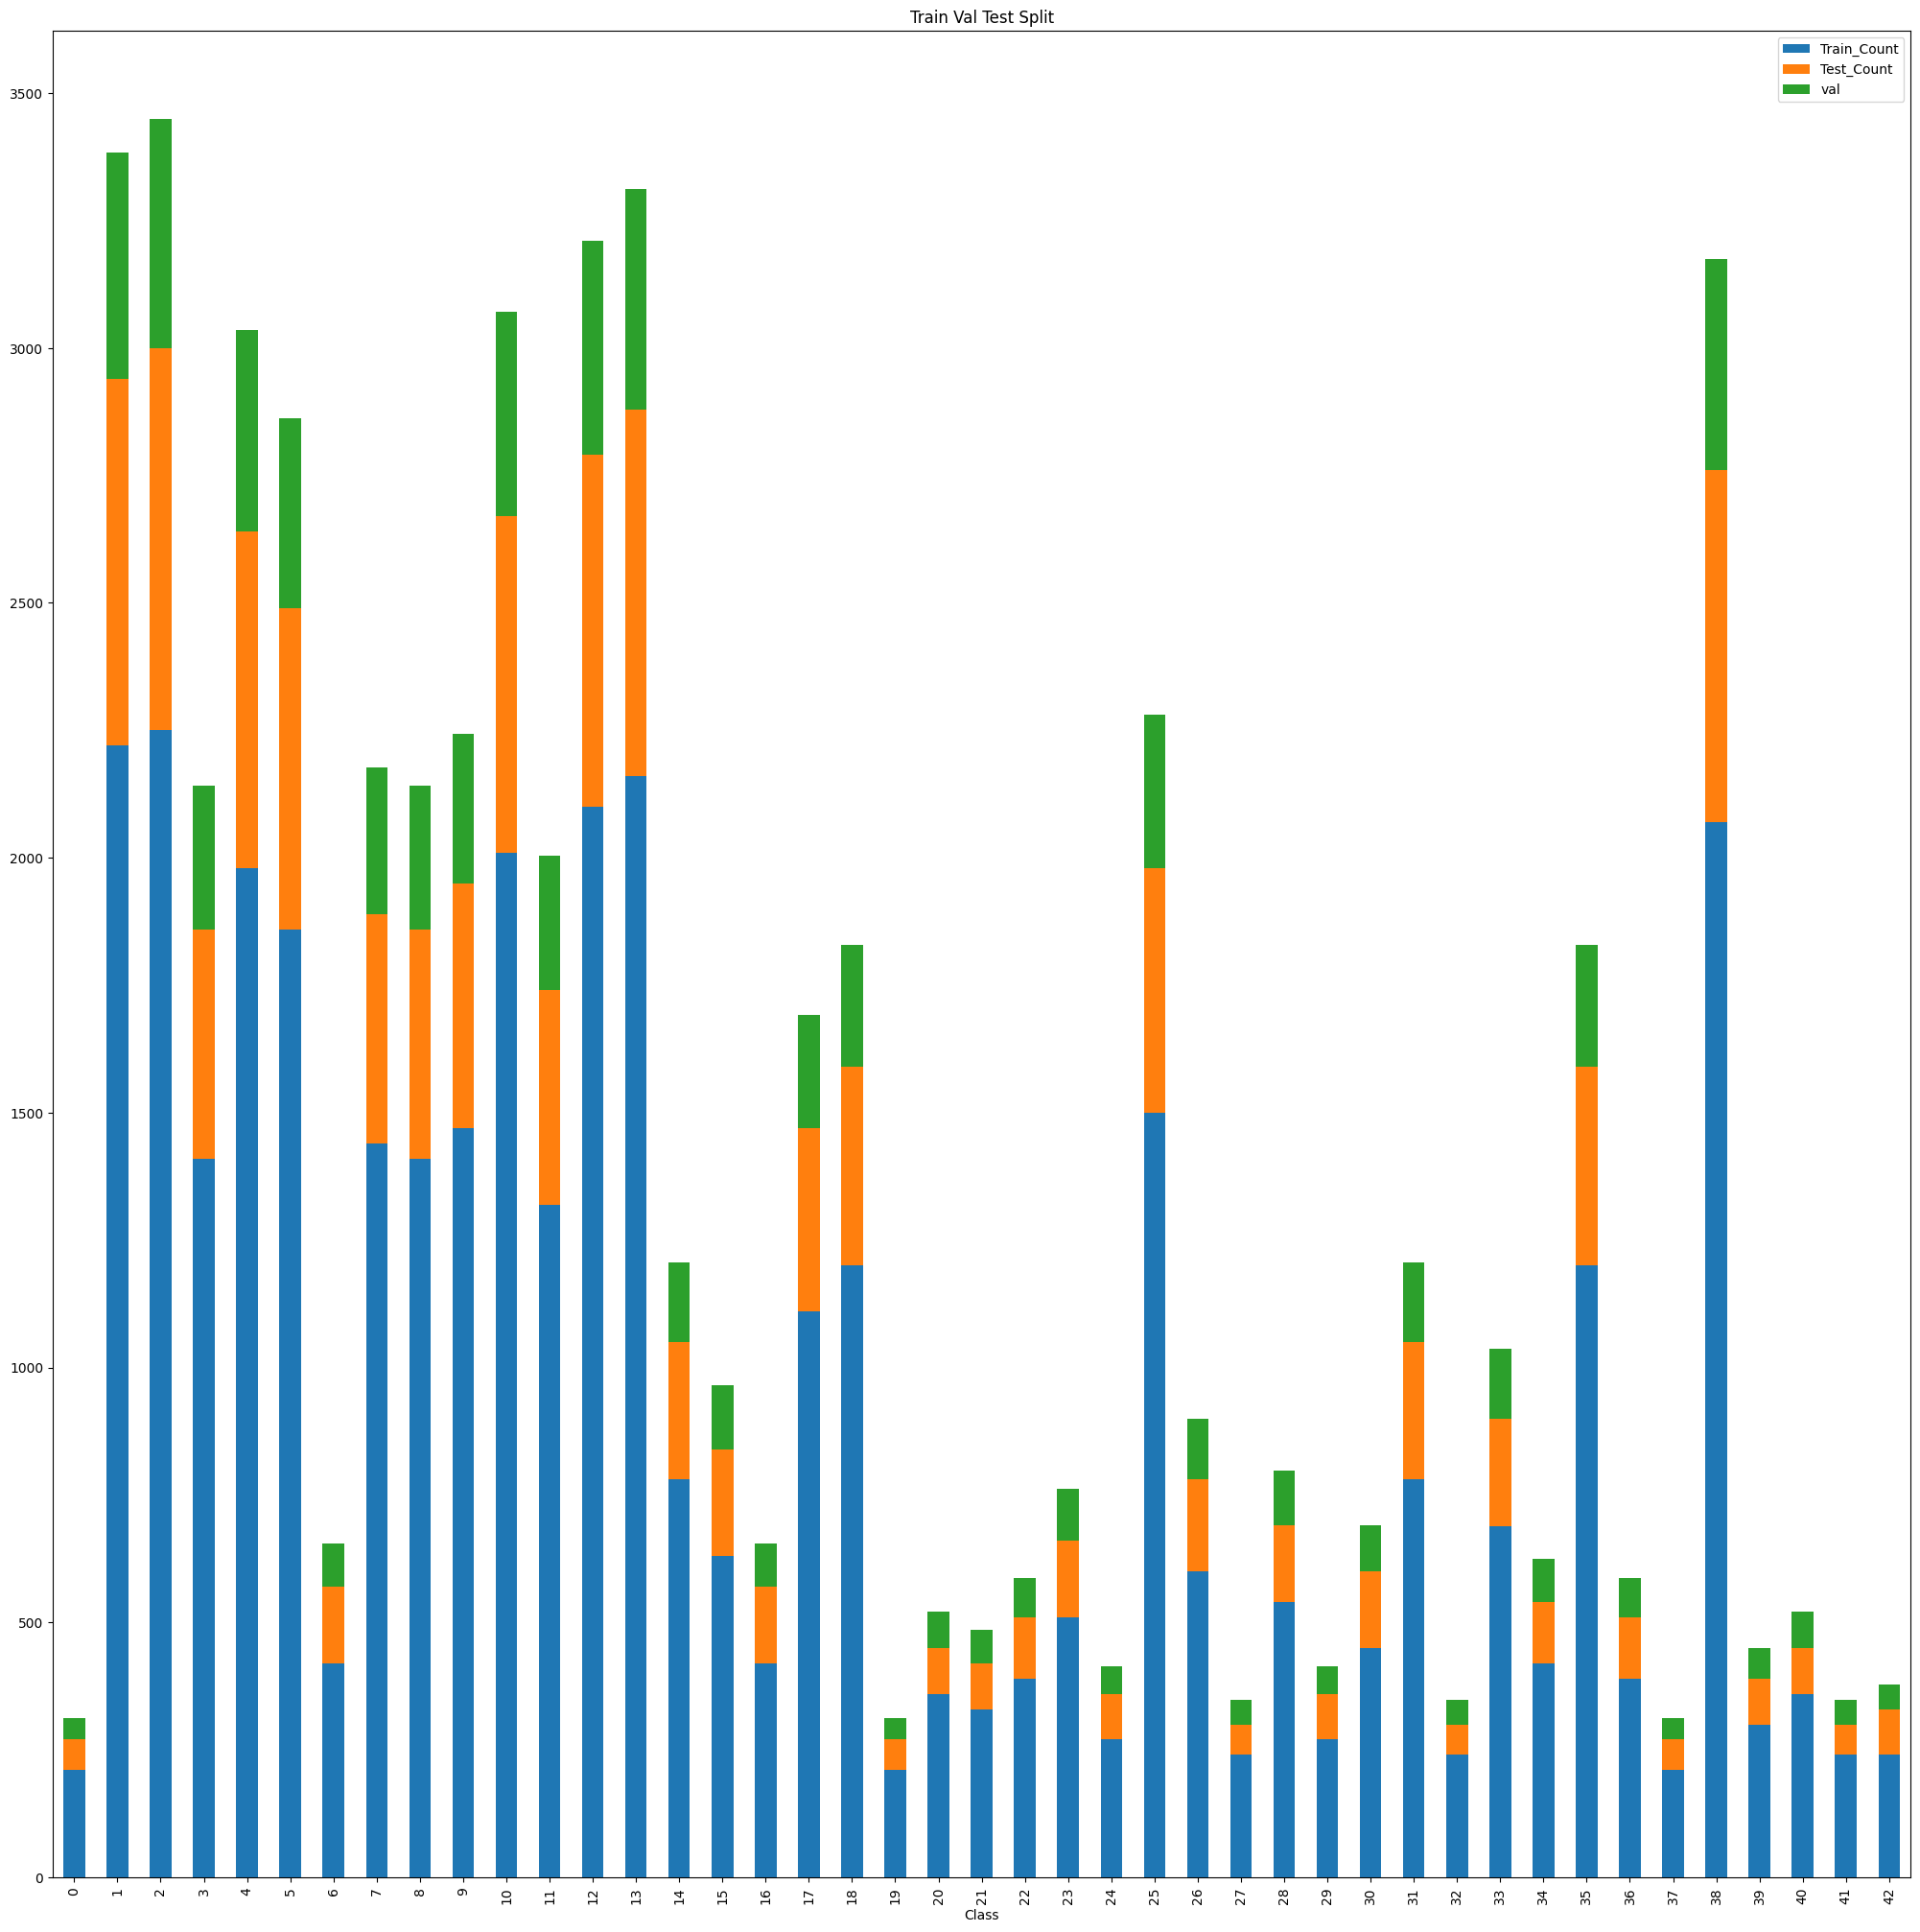

In [36]:
balance_analysis.plot.bar(x = 'Class', y = ['Train_Count', 'Test_Count', 'val'], figsize = (25, 25), stacked = True, title = "Train Val Test Split")

In [37]:
#MODEL CNN

In [38]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (31367, 32, 32, 3)
y_train shape: (31367,)
X_val shape: (7842, 32, 32, 3)
y_val shape: (7842,)


In [39]:
print("Sample y_train:", y_train[0])

Sample y_train: 12


In [40]:
# we are gonna do one-hot encoding conversion so the algorithm can process(into single format numerical)
# Before conversion
print("Original y_train shape:", y_train.shape)
print("Sample y_train value:", y_train[0])

# After conversion
print("One-hot y_train shape:", y_train.shape)
print("Sample one-hot y_train:", y_train[0])

Original y_train shape: (31367,)
Sample y_train value: 12
One-hot y_train shape: (31367,)
Sample one-hot y_train: 12


In [41]:
from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoding
num_classes = 43
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# Verify the shapes
print("y_train shape:", y_train.shape)  # Should be (num_samples, 43)
print("y_val shape:", y_val.shape)      # Should be (num_samples, 43)

y_train shape: (31367, 43)
y_val shape: (7842, 43)


In [42]:
#building the model & fitting the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np

def get_compiled_model(input_shape=(32, 32, 3), num_classes=43):
    """Create and compile a CNN model for traffic sign classification"""
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

# Example usage:
# 1. Prepare your data first (make sure it's properly normalized)
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# 2. Create and compile the model
model = get_compiled_model(input_shape=X_train.shape[1:])

# 3. Verify the model architecture
model.summary()

# 4. Train the model
history = model.fit(X_train, y_train,
                   batch_size=32,
                   epochs=20,
                   validation_data=(X_val, y_val),
                   verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

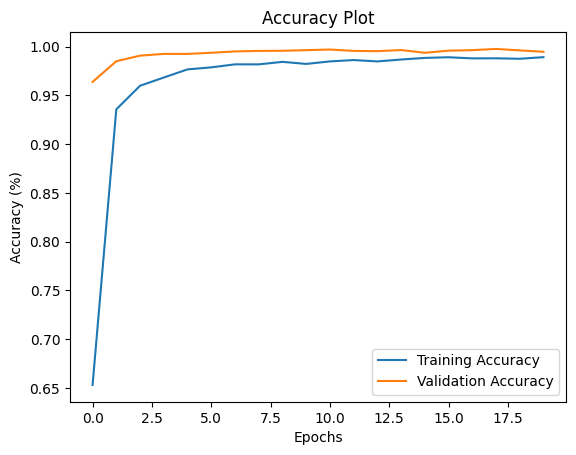

In [43]:
#accuracy plot
plt.figure()
plt.plot(history.history['accuracy'], label = "Training Accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

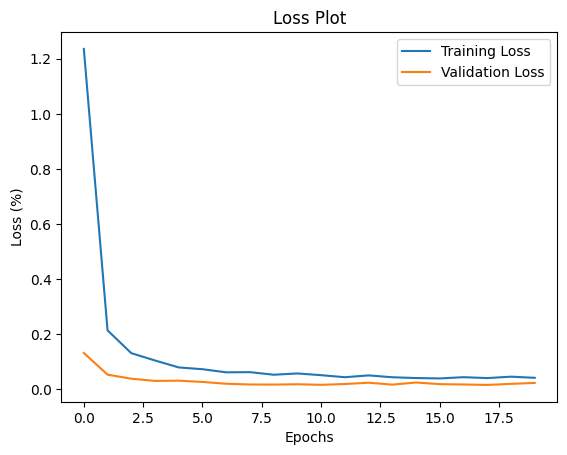

In [44]:
#loss plot
plt.figure()
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.legend()
plt.show()

In [45]:
#Inference
predictions = model.predict(X_test,verbose=1).argmax(axis=1)

395/395 [==============================] - 4s 10ms/step


In [46]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
cfm = confusion_matrix(y_test, predictions)

In [47]:
accuracy_score(y_test, predictions)

0.9555819477434679

<AxesSubplot:>

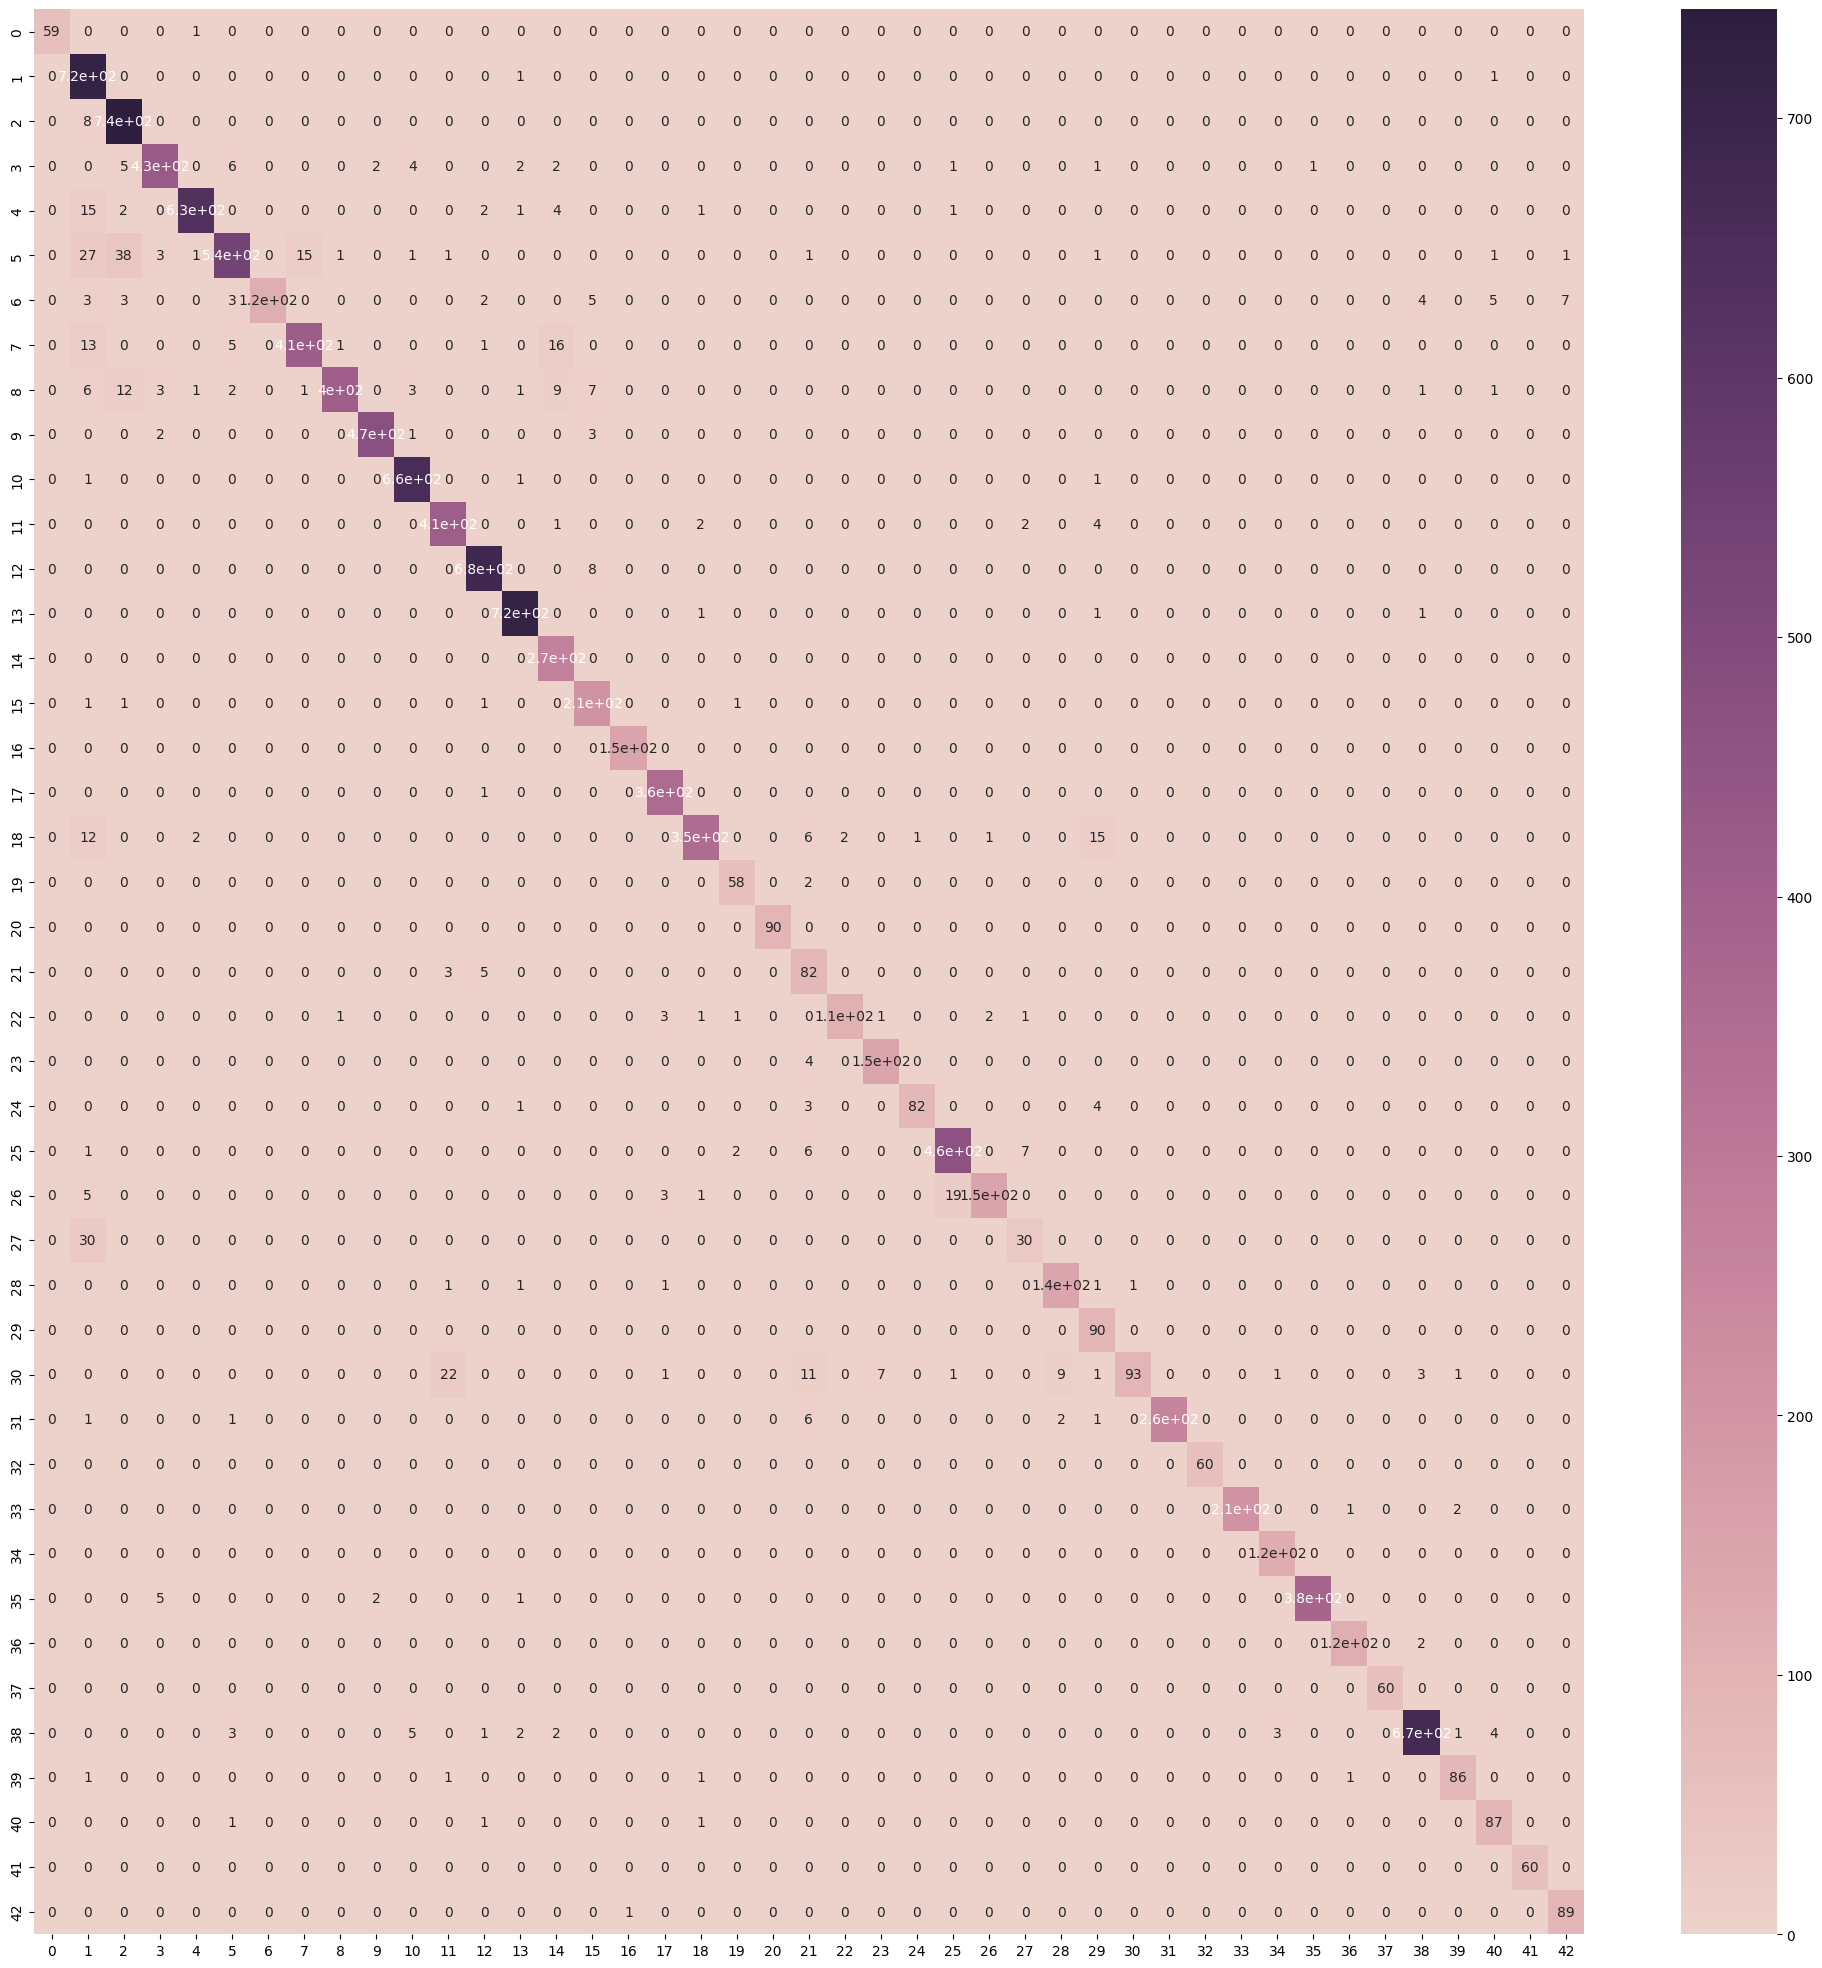

In [48]:
df_cfm = pd.DataFrame(cfm, index = [i for i in range(num_classes)], columns = [i for i in range(num_classes)])
plt.figure(figsize = (25, 25))
sns.heatmap(df_cfm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

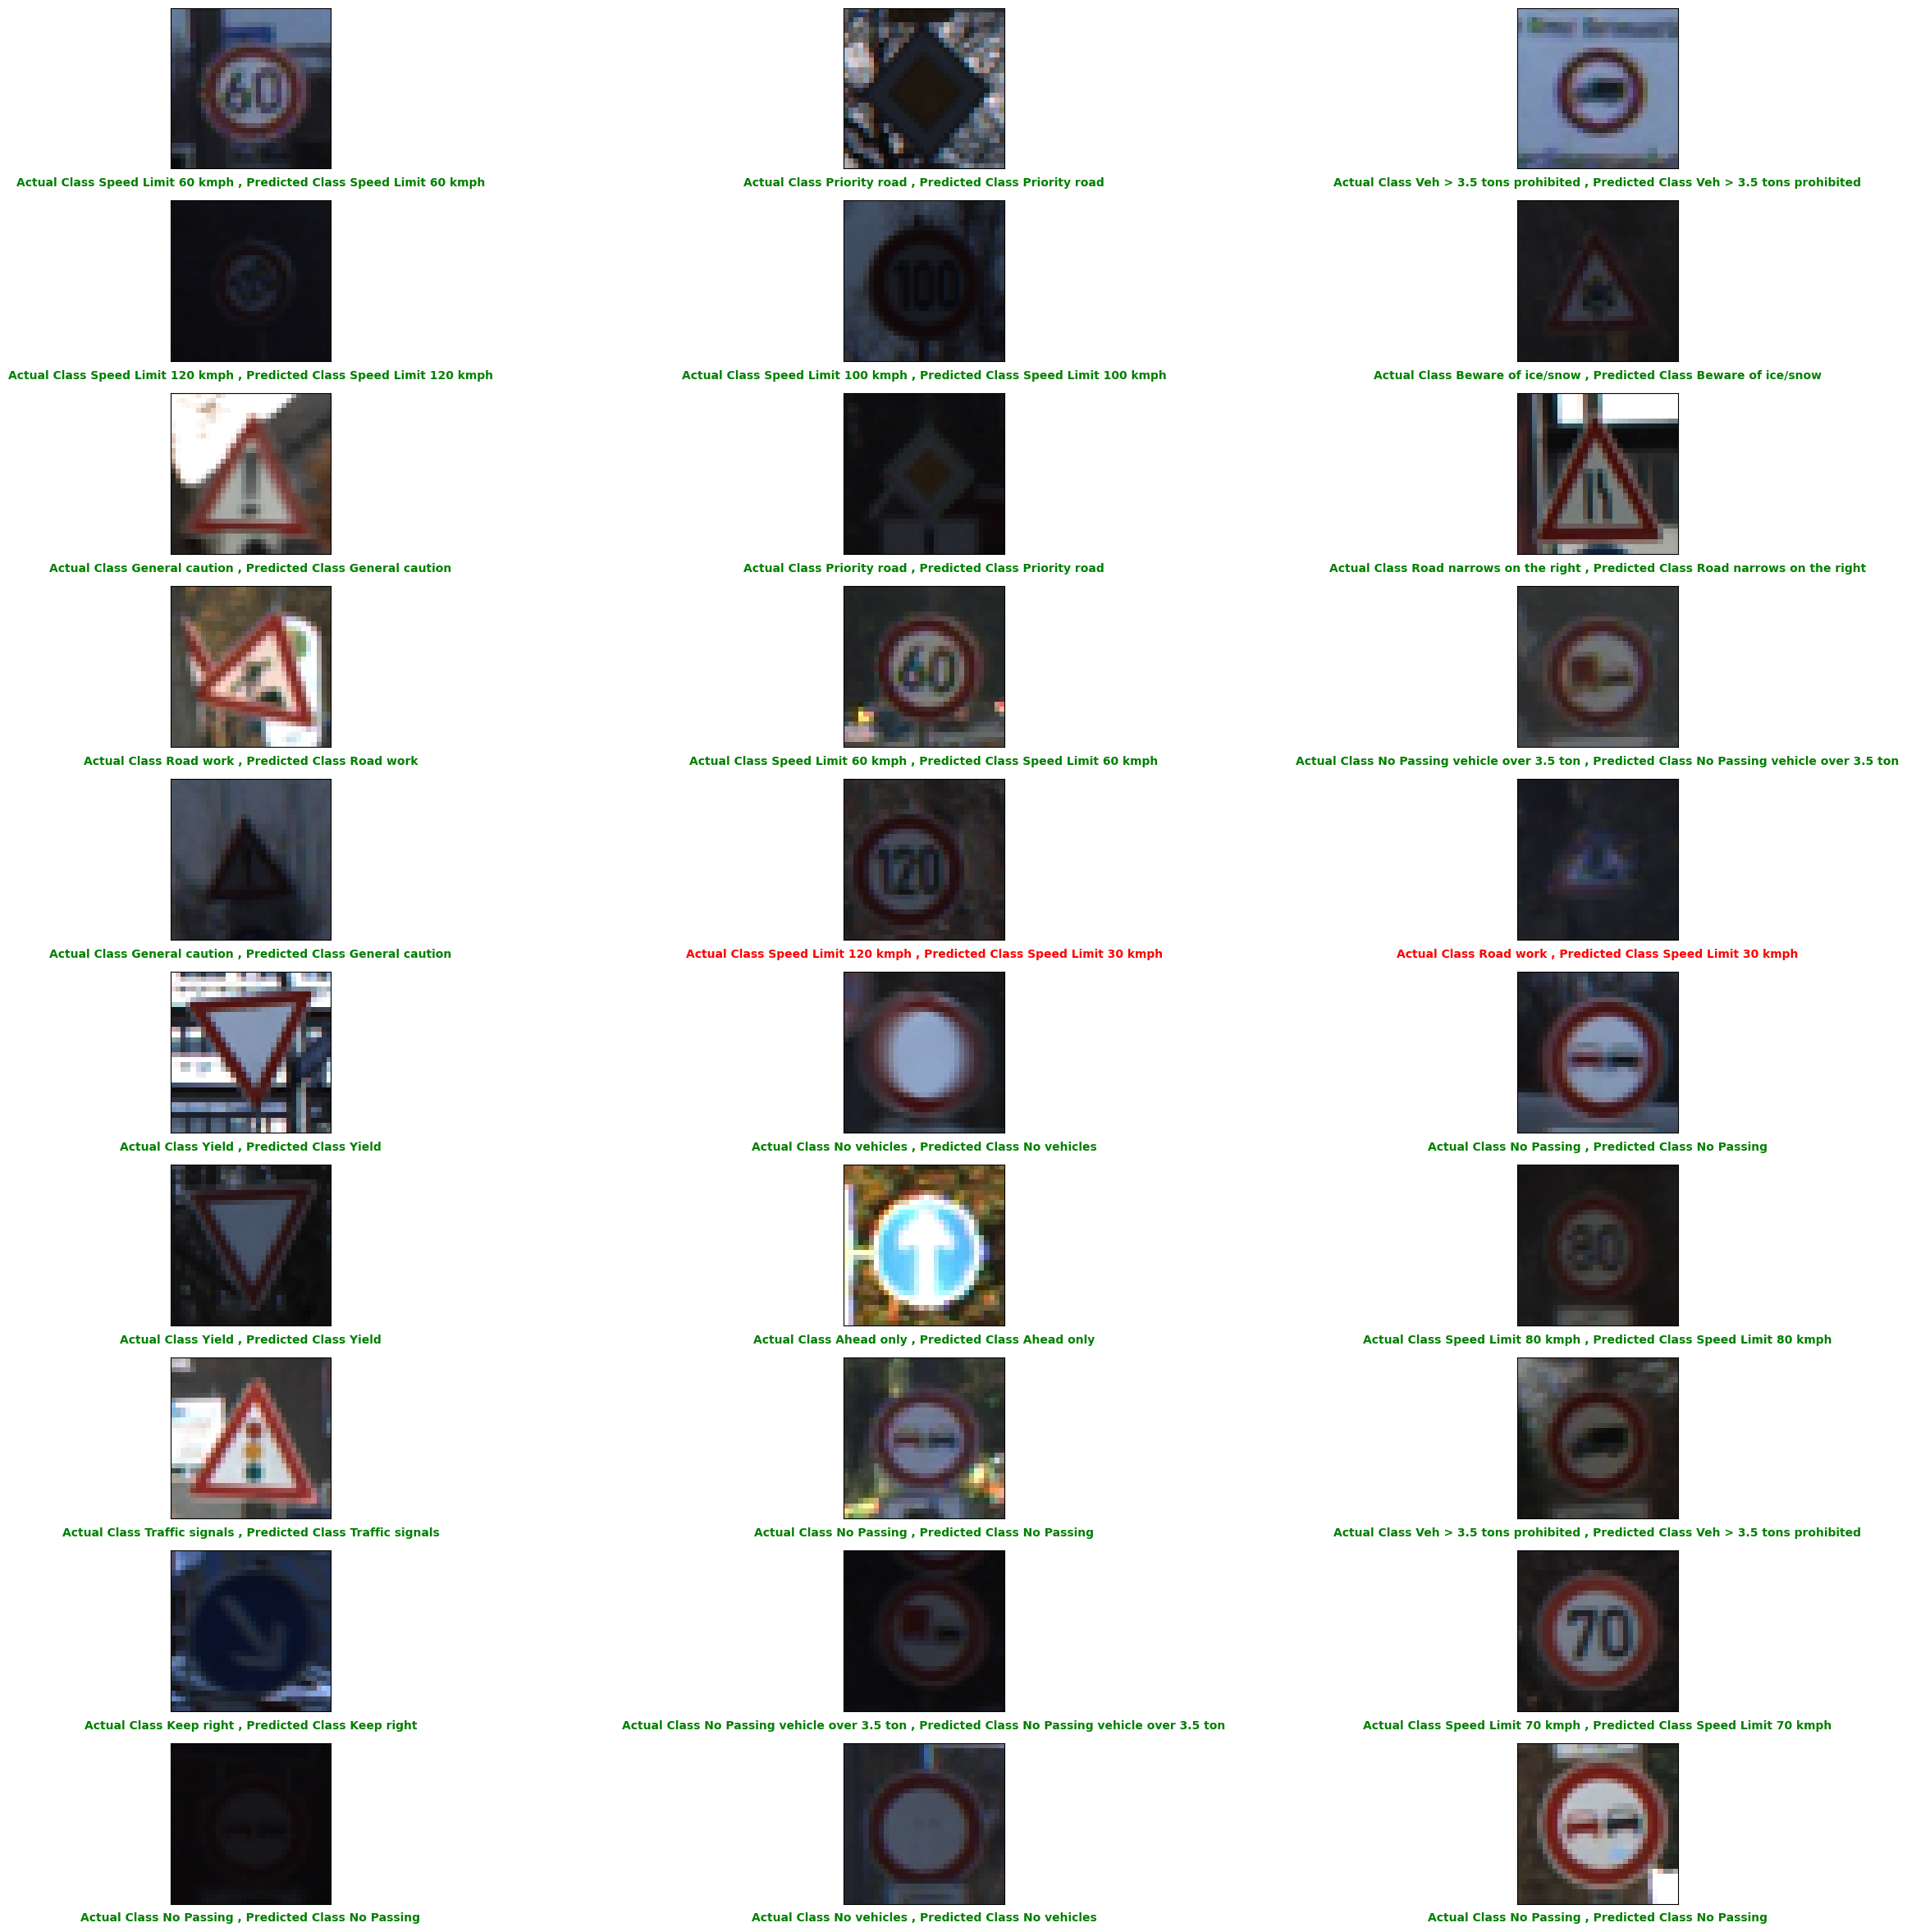

In [49]:
plt.figure(figsize = (30, 30))
start_index = 36
for i in range(30):
    plt.subplot(10, 3, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = predictions[start_index + i]
    ground_truth = y_test[start_index + i]
    col = 'g'
    if prediction != ground_truth:
        col = 'r'
    plt.xlabel('Actual Class {} , Predicted Class {}'.format(class_dict[ground_truth], class_dict[prediction]), color = col, weight = 'bold')
    plt.imshow(X_test[start_index + i])
plt.show()

In [50]:
os.mkdir('models')
model.save('models/traffic_sign_detection_gtsrb.h5')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'models'